In [228]:
import pandas as pd
import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import json 

#plot confusion matrix
from sklearn.metrics import confusion_matrix




# Load the Dataset

In [229]:
df = pandas = pd.read_csv('../German_Credit_data/Data/german.data', sep=' ')
df

,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1.1
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
2,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
3,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
4,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
995,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
996,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
997,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


# Da die Attributsnamen kodiert sind werden diese zu erst mithilfe der zugehörigen Dokumentation ersetzt. (Siehe Categorical.json)


In [230]:
file_path = "../German_Credit_data/Data/german.data"

names = ['Status Checking', 'Duration in Month', 'Credit History', 'Purpose', 'Credit Amount', 
         'Savings Account', 'Employement since', 'Installmentrate %', 'StatusSex', 'Otherdebtos', 
         'PresentResidence', 'Property', 'Age in years', 'Otherinstallment Plans', 'Housing', 
         'Number existing Credits', 'Job', 'Number people liable', 'Telephone', 'Foreign Worker', 'Target']
german_data = pd.read_csv(file_path,names=names,delim_whitespace=True, header=None)
catgories = open('../German_Credit_data/Data/categorical.json')
json_data = json.load(catgories)
json_data
for h in names:
    if h in json_data:
        german_data[h] = german_data[h].map(json_data[h])

In [231]:
german_data.head(5)

,Status Checking,Duration in Month,Credit History,Purpose,Credit Amount,Savings Account,Employement since,Installmentrate %,StatusSex,Otherdebtos,...,Property,Age in years,Otherinstallment Plans,Housing,Number existing Credits,Job,Number people liable,Telephone,Foreign Worker,Target
0,less than 0 DM,6,critical account / other credits existing (not...,radio/television,1169,unknown / no savings account,bigger than or equal 7 years,4,male : single,None,...,real estate,67,None,own,2,skilled employee /official,1,"yes, registered under the customers name",yes,1
1,0 less than or equal and less than 200 DM,48,existing credits paind back duly till now,radio/television,5951,less than 100DM,1 less than or equal and less than 4 years,2,female : divorced/separated/married,None,...,real estate,22,None,own,1,skilled employee /official,1,None,yes,2
2,no checking account,12,critical account / other credits existing (not...,education,2096,less than 100DM,4 less than and equal and less than 7 years,2,male : single,None,...,real estate,49,None,own,1,unskilled-resident,2,None,yes,1
3,less than 0 DM,42,existing credits paind back duly till now,furniture/equipment,7882,less than 100DM,4 less than and equal and less than 7 years,2,male : single,guarantor,...,if not real estate : building society savings ...,45,None,for free,1,skilled employee /official,2,None,yes,1
4,less than 0 DM,24,delay in paying off in the past,car (new),4870,less than 100DM,1 less than or equal and less than 4 years,3,male : single,None,...,unknown/no property,53,None,for free,2,skilled employee /official,2,None,yes,2


In [232]:
import dataframe_image as dfi
german_data.head(5).dfi.export('df.png')

objc[55816]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4328e948) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/102.0.5005.61/Libraries/libGLESv2.dylib (0x10e9c9290). One of the two will be used. Which one is undefined.
[0603/100633.033342:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/kg6tbnbs6md8psmvxmk30hmw0000gn/T/tmpfltn6vdz/temp.png.
objc[55837]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4328e948) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/102.0.5005.61/Libraries/libGLESv2.dylib (0x10868a290). One of the two will be used. Which one is undefined.
[0603/100635.195353:INFO:headless_shell.cc(6

In [233]:
# check for missing values
german_data.isnull().sum()


Status Checking            0
Duration in Month          0
Credit History             0
Purpose                    0
Credit Amount              0
Savings Account            0
Employement since          0
Installmentrate %          0
StatusSex                  0
Otherdebtos                0
PresentResidence           0
Property                   0
Age in years               0
Otherinstallment Plans     0
Housing                    0
Number existing Credits    0
Job                        0
Number people liable       0
Telephone                  0
Foreign Worker             0
Target                     0
dtype: int64

In [234]:
df_styled = german_data.describe().style.background_gradient()

# Daten auf Plausibilität prüfen

In [235]:
# describe the data
dfi.export(df_styled, 'df_stats.png')


/Users/danielhorn/opt/anaconda3/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
objc[55868]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb4328e948) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/102.0.5005.61/Libraries/libGLESv2.dylib (0x111e05290). One of the two will be used. Which one is undefined.
[0603/100643.940435:INFO:headless_shell.cc(660)] Written to file /var/folders/rf/kg6tbnbs6md8psmvxmk30hmw0000gn/T/tmp_we1_6ug/temp.png.


<AxesSubplot:>

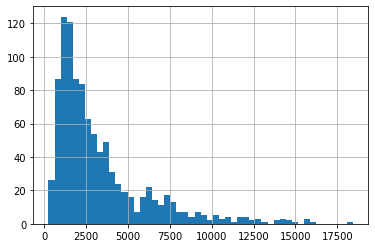

In [236]:
#check credit amount for outliers
german_data['Credit Amount'].hist(bins=50)
# x achse log 



<AxesSubplot:ylabel='Frequency'>

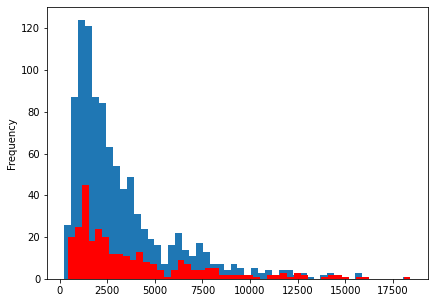

In [237]:
plt.subplot(1, 2, 1)
german_data['Credit Amount'].plot(kind='hist', logx=False, bins=50)
# plot histogram credit amout where target is 2
german_data.loc[german_data['Target'] == 2, 'Credit Amount'].plot(kind='hist', logx=False, bins=50, color='red', figsize=(15, 5))


<AxesSubplot:ylabel='Target'>

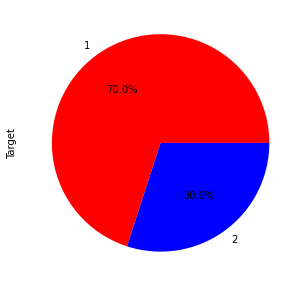

In [238]:
# plot target variable as pie chart with target 1 and target 2 as labels colored red and blue

german_data['Target'].value_counts().plot(kind='pie', colors=['red', 'blue'], autopct='%1.1f%%', figsize=(15, 5))

# Zielvariable ist Ungleichverteilt

# Untersuchung auf Outlier

<AxesSubplot:title={'center':'Credit Amount'}, xlabel='Target'>

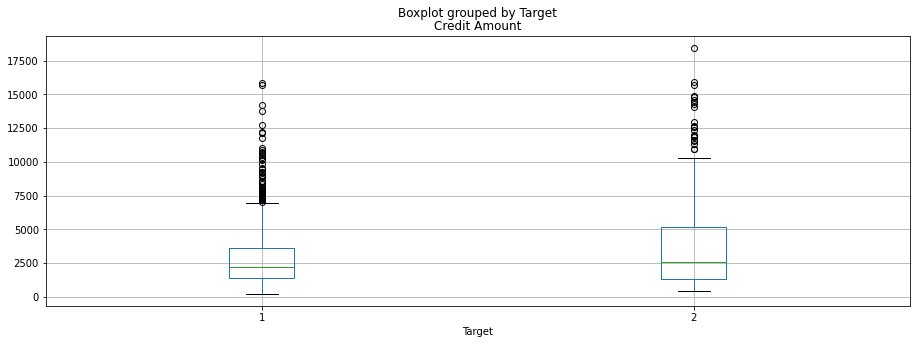

In [239]:
#box plot credit amount outliers
german_data.boxplot(column='Credit Amount', by='Target', figsize=(15, 5))

<AxesSubplot:xlabel='Credit Amount', ylabel='Target'>

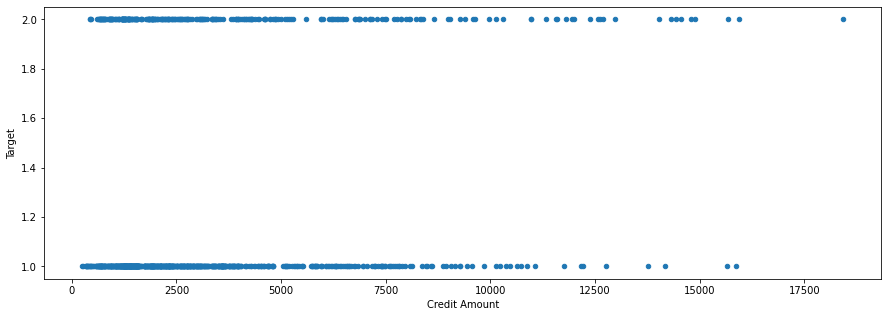

In [240]:
# scatter plot credit amount
german_data.plot(kind='scatter', x='Credit Amount', y='Target', figsize=(15, 5))

<AxesSubplot:>

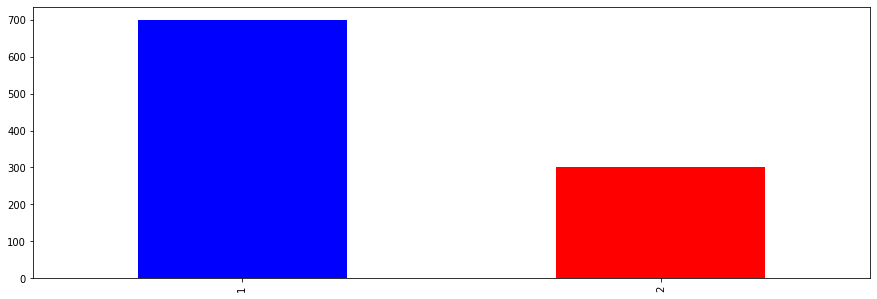

In [241]:
# plot distribution of target variable with color 2 as red and color 1 as blue

german_data['Target'].value_counts().plot(kind='bar', figsize=(15, 5), color=['blue', 'red'])

In [242]:
# calculate ZScore for credit amount --> for outlier detection
german_data['ZScore'] = (german_data['Credit Amount'] - german_data['Credit Amount'].mean()) / german_data['Credit Amount'].std()
#plot zscore for credit amount
german_data['ZScore'].plot(kind='hist', bins=50, figsize=(15, 5))

In [244]:
# calculate IQR for credit amount
def outlier_detection(df):
    Q1 = np.percentile(german_data['Credit Amount'], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(german_data['Credit Amount'], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1

    upper = Q3 +1.5*IQR
    lower = Q1 - 1.5*IQR
    upper = german_data['Credit Amount'] >= (Q3+1.5*IQR)
    
    print("Upper bound:",upper)
    print(np.where(upper))
    
    # Below Lower bound
    lower = german_data['Credit Amount'] <= (Q1-1.5*IQR)
    print("Lower bound:", lower)
    print(np.where(lower))
outlier_detection(german_data)

Upper bound: 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Credit Amount, Length: 1000, dtype: bool
(array([  5,  17,  18,  57,  63,  70,  78,  87,  95, 105, 130, 134, 136,
       180, 205, 226, 236, 268, 272, 274, 285, 291, 295, 304, 333, 373,
       374, 378, 381, 395, 402, 417, 431, 450, 491, 496, 509, 525, 549,
       563, 615, 616, 637, 645, 653, 657, 672, 684, 714, 736, 744, 763,
       771, 805, 808, 812, 818, 828, 832, 854, 881, 887, 895, 902, 915,
       917, 921, 927, 945, 953, 980, 983]),)
Lower bound: 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Credit Amount, Length: 1000, dtype: bool
(array([], dtype=int64),)


/var/folders/rf/kg6tbnbs6md8psmvxmk30hmw0000gn/T/ipykernel_52151/4039486070.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(german_data['Credit Amount'], 25,
/var/folders/rf/kg6tbnbs6md8psmvxmk30hmw0000gn/T/ipykernel_52151/4039486070.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(german_data['Credit Amount'], 75,


In [245]:
# function to determine outlier values
def outlier_iqr(df):
    quartile_1, quartile_3 = np.percentile(df, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((df > upper_bound) | (df < lower_bound))
# calculate the outlier values
outlier_iqr(german_data['Credit Amount'])

(array([  5,  17,  18,  57,  63,  70,  78,  87,  95, 105, 130, 134, 136,
        180, 205, 226, 236, 268, 272, 274, 285, 291, 295, 304, 333, 373,
        374, 378, 381, 395, 402, 417, 431, 450, 491, 496, 509, 525, 549,
        563, 615, 616, 637, 645, 653, 657, 672, 684, 714, 736, 744, 763,
        771, 805, 808, 812, 818, 828, 832, 854, 881, 887, 895, 902, 915,
        917, 921, 927, 945, 953, 980, 983]),)

In [246]:
# transform target value 2 to 1 and 1 to 0 to be binary
# 0 = good credit ; 1 = bad credit
german_data['Target'] = german_data['Target'].map({2:1, 1:0})

# map value 0 to string "good" credit and 1 to "bad" credit
#german_data['Target'] = german_data['Target'].map({0:'good', 1:'bad'})



In [247]:
german_data['Target'].value_counts()

0    700
1    300
Name: Target, dtype: int64

In [248]:
#iterate through feautures and get datatype and check if they are categorical or numerical and store them into list for one hot encoding
categorical_features = []
numerical_features = []
for i in german_data.columns:
    print(i, german_data[i].dtype)
    if german_data[i].dtype == 'object':
        print(i, german_data[i].dtype)
        categorical_features.append(i)
    else:
        print(i, german_data[i].dtype)
        numerical_features.append(i)


print(categorical_features, "Numerical:" ,numerical_features)
    


Status Checking object
Status Checking object
Duration in Month int64
Duration in Month int64
Credit History object
Credit History object
Purpose object
Purpose object
Credit Amount int64
Credit Amount int64
Savings Account object
Savings Account object
Employement since object
Employement since object
Installmentrate % int64
Installmentrate % int64
StatusSex object
StatusSex object
Otherdebtos object
Otherdebtos object
PresentResidence int64
PresentResidence int64
Property object
Property object
Age in years int64
Age in years int64
Otherinstallment Plans object
Otherinstallment Plans object
Housing object
Housing object
Number existing Credits int64
Number existing Credits int64
Job object
Job object
Number people liable int64
Number people liable int64
Telephone object
Telephone object
Foreign Worker object
Foreign Worker object
Target int64
Target int64
ZScore float64
ZScore float64
['Status Checking', 'Credit History', 'Purpose', 'Savings Account', 'Employement since', 'StatusSex'

In [249]:
german_data

,Status Checking,Duration in Month,Credit History,Purpose,Credit Amount,Savings Account,Employement since,Installmentrate %,StatusSex,Otherdebtos,...,Age in years,Otherinstallment Plans,Housing,Number existing Credits,Job,Number people liable,Telephone,Foreign Worker,Target,ZScore
0,less than 0 DM,6,critical account / other credits existing (not...,radio/television,1169,unknown / no savings account,bigger than or equal 7 years,4,male : single,None,...,67,None,own,2,skilled employee /official,1,"yes, registered under the customers name",yes,0,-0.744759
1,0 less than or equal and less than 200 DM,48,existing credits paind back duly till now,radio/television,5951,less than 100DM,1 less than or equal and less than 4 years,2,female : divorced/separated/married,None,...,22,None,own,1,skilled employee /official,1,None,yes,1,0.949342
2,no checking account,12,critical account / other credits existing (not...,education,2096,less than 100DM,4 less than and equal and less than 7 years,2,male : single,None,...,49,None,own,1,unskilled-resident,2,None,yes,0,-0.416354
3,less than 0 DM,42,existing credits paind back duly till now,furniture/equipment,7882,less than 100DM,4 less than and equal and less than 7 years,2,male : single,guarantor,...,45,None,for free,1,skilled employee /official,2,None,yes,0,1.633430
4,less than 0 DM,24,delay in paying off in the past,car (new),4870,less than 100DM,1 less than or equal and less than 4 years,3,male : single,None,...,53,None,for free,2,skilled employee /official,2,None,yes,1,0.566380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,existing credits paind back duly till now,furniture/equipment,1736,less than 100DM,4 less than and equal and less than 7 years,3,female : divorced/separated/married,None,...,31,None,own,1,unskilled-resident,1,None,yes,0,-0.543890
996,less than 0 DM,30,existing credits paind back duly till now,car (used),3857,less than 100DM,1 less than or equal and less than 4 years,4,male : divorced/separated,None,...,40,None,own,1,management/self-employed/highly qualified empl...,1,"yes, registered under the customers name",yes,0,0.207509
997,no checking account,12,existing credits paind back duly till now,radio/television,804,less than 100DM,bigger than or equal 7 years,4,male : single,None,...,38,None,own,1,skilled employee /official,1,None,yes,0,-0.874066
998,less than 0 DM,45,existing credits paind back duly till now,radio/television,1845,less than 100DM,1 less than or equal and less than 4 years,4,male : single,None,...,23,None,for free,1,skilled employee /official,1,"yes, registered under the customers name",yes,1,-0.505275


In [250]:
# one hot encode categorical features
german_data = pd.get_dummies(german_data, columns=categorical_features)



In [251]:
german_data.shape

(1000, 63)

# Untersuchung auf Korrelation

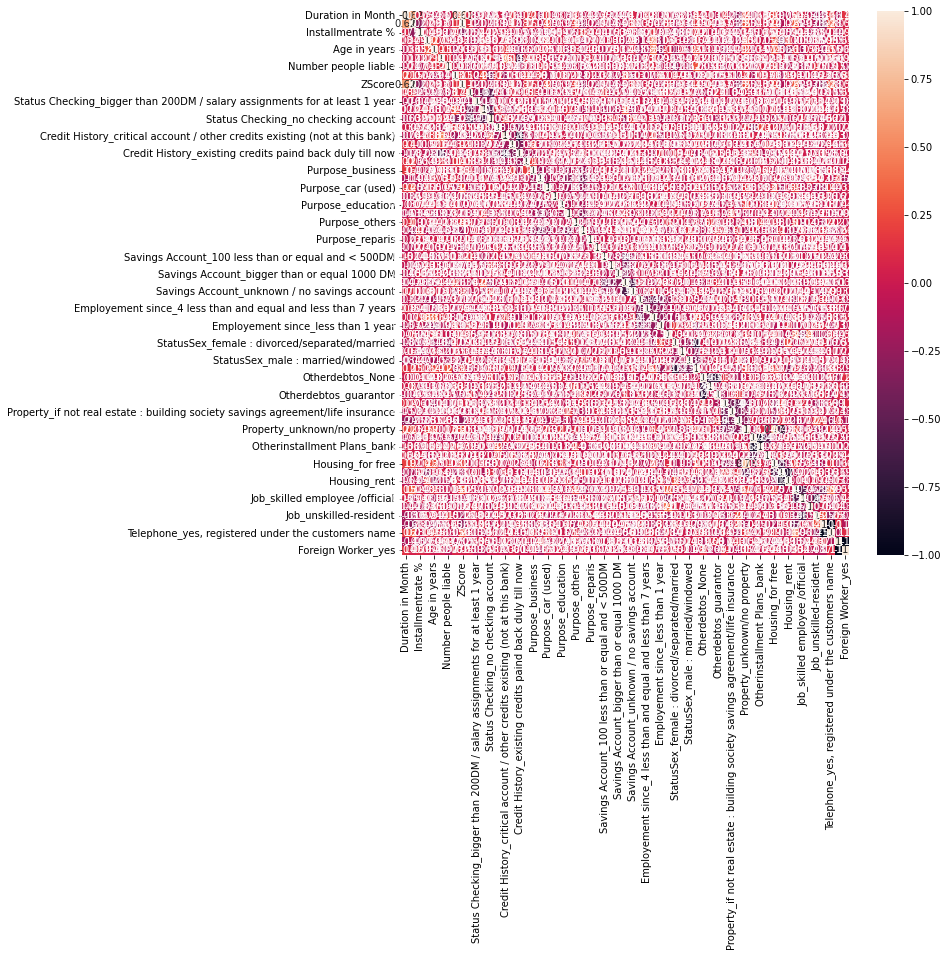

 Positive Correlations:
 Status Checking_no checking account                                           -0.322436
Credit History_critical account / other credits existing (not at this bank)   -0.181713
Housing_own                                                                   -0.134589
Savings Account_unknown / no savings account                                  -0.129238
Property_real estate                                                          -0.119300
                                                                                 ...   
ZScore                                                                         0.154739
Savings Account_less than 100DM                                                0.161007
Duration in Month                                                              0.214927
Status Checking_less than 0 DM                                                 0.258333
Target                                                                         1.000000
Name: T

In [252]:
# function to calculate correlation between target and feautures 
# onöy plot the 5 most correlated features with target variable

def correlation_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(10,10))
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

    correlations = df.corr()['Target'].sort_values()

    # Display correlations
    print(' Positive Correlations:\n', correlations)
    print(' Negative Correlations:\n', correlations)

correlation_matrix(german_data)

In [253]:
#drop zscore
german_data = german_data.drop(['ZScore'], axis=1)


# Basic Modelling with Logistic Regression as Baseline, xGboost and a neuronal Network

In [254]:
# create dictionary with algo name and recall score

Non_opt_results_recall = {"Algo_name": [], "Recall": [],"Accuracy": []}

In [255]:
# use logistic regression to predict target variable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, fbeta_score

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(german_data.drop('Target', axis=1), german_data['Target'], test_size=0.28, random_state=42)

# create logistic regression model
'''
solver to liblinear --> better score; standard lbfgs
'''
logreg = LogisticRegression(max_iter=100, intercept_scaling=100, solver = 'liblinear')
# fit the model
logreg.fit(X_train, y_train)
# predict the target variable
y_pred = logreg.predict(X_test)

# print accuracy score and recall score
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("fbeta score:", fbeta_score(y_test, y_pred, beta=2))

# add algo name and recall score to dictionary
Non_opt_results_recall["Algo_name"].append("Logistic Regression")
Non_opt_results_recall["Recall"].append(recall_score(y_test, y_pred))
Non_opt_results_recall["Accuracy"].append(accuracy_score(y_test, y_pred))




Accuracy score: 0.7678571428571429
Recall score: 0.4880952380952381
Precision score: 0.6507936507936508
fbeta score: 0.5137844611528822


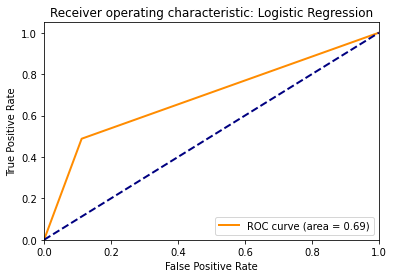

In [256]:
#plot roc curve
from sklearn.metrics import roc_curve, auc
#plot roc curve
def plot_roc_curve(y_test, y_pred,label):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: '+label)
    plt.legend(loc="lower right")
    plt.show()
# call the function roc curve
plot_roc_curve(y_test, y_pred,"Logistic Regression")

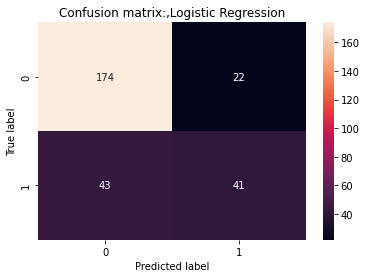

In [257]:
confusion_matrix = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(label):
    #plot confusion matrix with labels
    plt.figure()
    sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.title('Confusion matrix:'+ label)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# plot confusion matrix
plot_confusion_matrix("Logistic Regression")


In [258]:
# use random forest to predict target variable
from sklearn.ensemble import RandomForestClassifier
# fit the model
rf = RandomForestClassifier(n_estimators=1000, max_depth=1000, random_state=42)
rf.fit(X_train, y_train)
# predict the target variable
y_pred = rf.predict(X_test)
# print accuracy score and recall score
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("fbeta score:", fbeta_score(y_test, y_pred, beta=2))

Non_opt_results_recall["Algo_name"].append("Random Forest")
Non_opt_results_recall["Recall"].append(recall_score(y_test, y_pred))
Non_opt_results_recall["Accuracy"].append(accuracy_score(y_test, y_pred))


Accuracy score: 0.7642857142857142
Recall score: 0.36904761904761907
Precision score: 0.7045454545454546
fbeta score: 0.4078947368421053


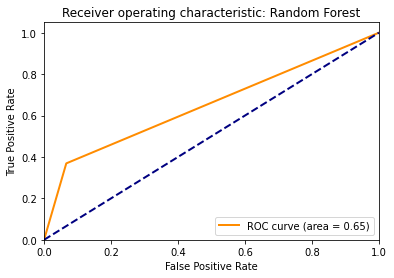

In [259]:
plot_roc_curve(y_test, y_pred,"Random Forest")

In [260]:
# use neuro network to predict target variable
# als baseline werden die Standardparameter verwendet
from sklearn.neural_network import MLPClassifier
# fit the model
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)
# predict the target variable
y_pred = nn.predict(X_test)
# print accuracy score and recall score
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("fbeta score:", fbeta_score(y_test, y_pred, beta=2))

Non_opt_results_recall["Algo_name"].append("Neural Network")
Non_opt_results_recall["Recall"].append(recall_score(y_test, y_pred))
Non_opt_results_recall["Accuracy"].append(accuracy_score(y_test, y_pred))

Accuracy score: 0.7035714285714286
Recall score: 0.40476190476190477
Precision score: 0.5074626865671642
fbeta score: 0.4218362282878413


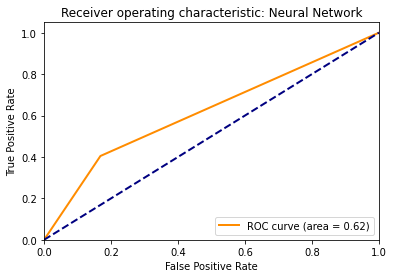

In [261]:
plot_roc_curve(y_test, y_pred,"Neural Network")

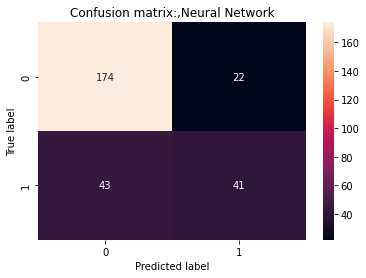

In [262]:
plot_confusion_matrix("Neural Network")


In [263]:
# use xgboost to predict target variable
from xgboost import XGBClassifier
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

# fit the model
xgb = XGBClassifier(n_estimators=1000, max_depth=1000, random_state=42)


xgb.fit(X_train, y_train)
# predict the target variable
y_pred = xgb.predict(X_test)
# print accuracy score and recall score
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("fbeta score:", fbeta_score(y_test, y_pred, beta=2))

Non_opt_results_recall["Algo_name"].append("xGboost")
Non_opt_results_recall["Recall"].append(recall_score(y_test, y_pred))
Non_opt_results_recall["Accuracy"].append(accuracy_score(y_test, y_pred))


Accuracy score: 0.7571428571428571
Recall score: 0.47619047619047616
Precision score: 0.625
fbeta score: 0.49999999999999994


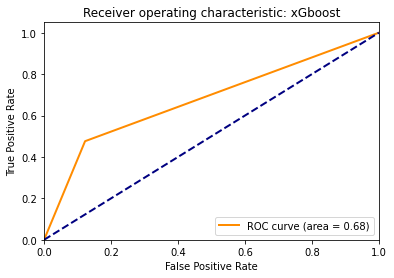

In [264]:
plot_roc_curve(y_test, y_pred,"xGboost")

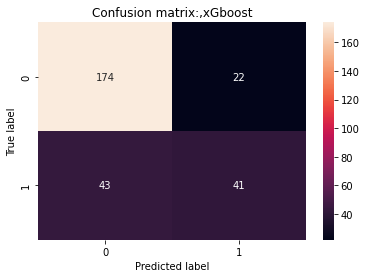

In [265]:
plot_confusion_matrix("xGboost")


# Ergebnisse nicht Optimierte Modelle


In [266]:
Non_opt_results_recall

{'Algo_name': ['Logistic Regression',
  'Random Forest',
  'Neural Network',
  'xGboost'],
 'Recall': [0.4880952380952381,
  0.36904761904761907,
  0.40476190476190477,
  0.47619047619047616],
 'Accuracy': [0.7678571428571429,
  0.7642857142857142,
  0.7035714285714286,
  0.7571428571428571]}

# Modells Optimized with Hyperparametertuning

In [267]:
#hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV
#tune hyperparameters
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'],'intercept_scaling': [100, 500, 1000, 5000, 10000]}
# create grid search object
grid_search = GridSearchCV(logreg, parameters, cv=5, scoring='accuracy')
# fit the model
grid_search.fit(X_train, y_train)
# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'C': 1, 'intercept_scaling': 10000, 'penalty': 'l2'}
Best score: 0.7402777777777778
